Exercise 2
## 1. Setting things up.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time
import numba
import pylab

# to print plots inline
%matplotlib inline

In [2]:
# Specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 0.03
w = 0.7
r= 0.04
z = 1
sigma_z = 0.213
mu = 0.000
rho = 0.7605
sizez = 9
betafirm = (1 / (1 + r))
params = alpha_k, alpha_l, delta, psi, w, r

In [7]:
# Set up K-grid
dens = 5
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2 * kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]


In [8]:
import sys
sys.path.append('../Code')
import ar1_approx as ar1
num_sigma = 4
step = (num_sigma * sigma_z) / (sizez / 2)
pi, zvec = ar1.rouwen(rho, mu, step, sizez)
zvec = np.exp(zvec)

In [9]:
# operating profits, op
def op(z, k, params):
    alpha_k, alpha_l, delta, psi, w, r = params
    op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) * ((k ** alpha_k) ** (1 / (1 - alpha_l)))) * z ** (1/(1 - alpha_l))
    return op

# firm cash flow, e
e = np.zeros((sizek, sizek, sizez))
for i in range(sizek):
    for j in range(sizek):
        for k in range(sizez):
            e[i, j, k] = (op(zvec[k], kvec[i], params) - kvec[j] + ((1 - delta) * kvec[i]) - psi * kvec[i])

## 2. Value Function Iteration.
The Bellman equation now becomes:  
$$ V(z,k) = max_{k'}\{ \pi(z,k) - I -\psi_1 k + \beta E_{z'|z}V(z',k'), \pi(z,k) + \beta E_{z'|z}V(z',(1-\delta k))\}$$

In [52]:
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((sizek, sizez))  # initial guess of value function
Vmat = np.zeros((sizek, sizek, sizez))  # initialize Vmat matrix for investing
Vmat1 = np.zeros((sizek, sizez)) # initialize Vmat matrix for not investing
Vmat2 = np.zeros((sizek, sizez))  # initialize Vmat matrix for maximal value if invest
VFiter = 1

while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    for i in range(sizek):  # loop over k
        if i < dens:
            Vmat1[i, k] = 0 
        else:
            for k in range(sizez): # loop over z
                Vmat1[i, k] = op(zvec[k], kvec[i], params) + betafirm * np.dot(V[i - dens, :], pi[:, k])
                for j in range(sizek): # loop over z'
                    Vmat[i, j, k] = e[i, j, k] + betafirm * np.dot(V[j, :], pi[:, k])
                Vmat2 = Vmat.max(axis=1) 
                
    V = np.maximum(Vmat1, Vmat2)
    
    # Get index for optimal k
    PF = np.argmax(Vmat, axis = 1)
    for i in range(sizek):
        for k in range(sizez):
            if V[i, k] == Vmat1[i, k]:
                PF[i, k] = i - dens
                
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1
    
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')

Value function converged after this many iterations: 361


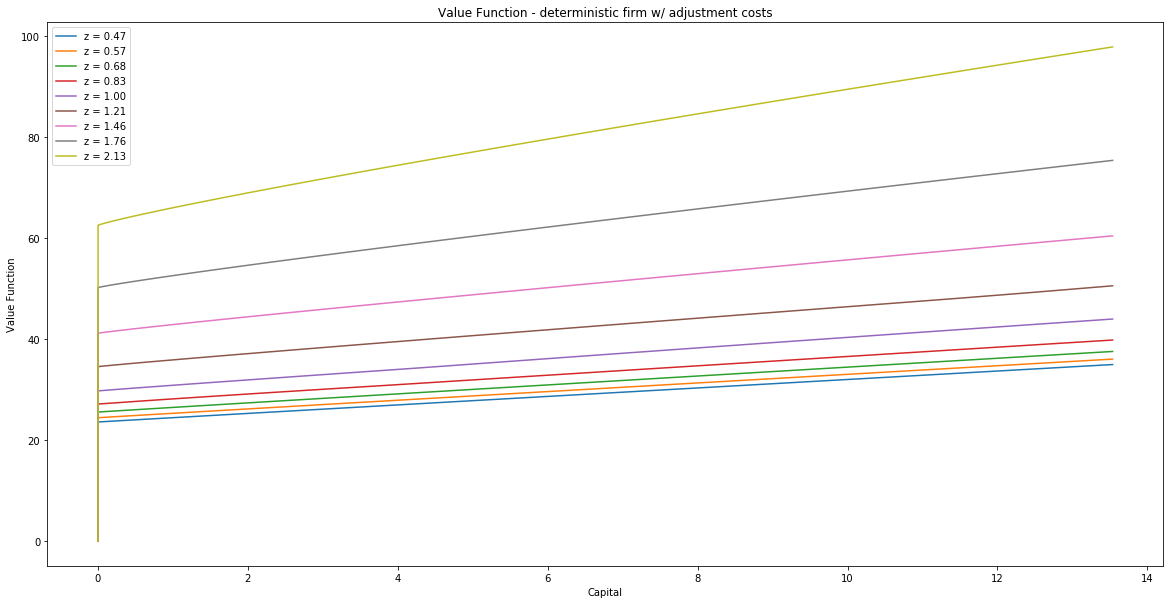

In [53]:
# Value Function Plots
pylab.rcParams['figure.figsize'] = (20, 10)
for i in range(9):
    plt.plot(kvec, V[:,i], label= str('z = ' + "%.2f" %zvec[i]))
plt.xlabel('Capital')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic firm w/ adjustment costs')
plt.legend()
plt.show()

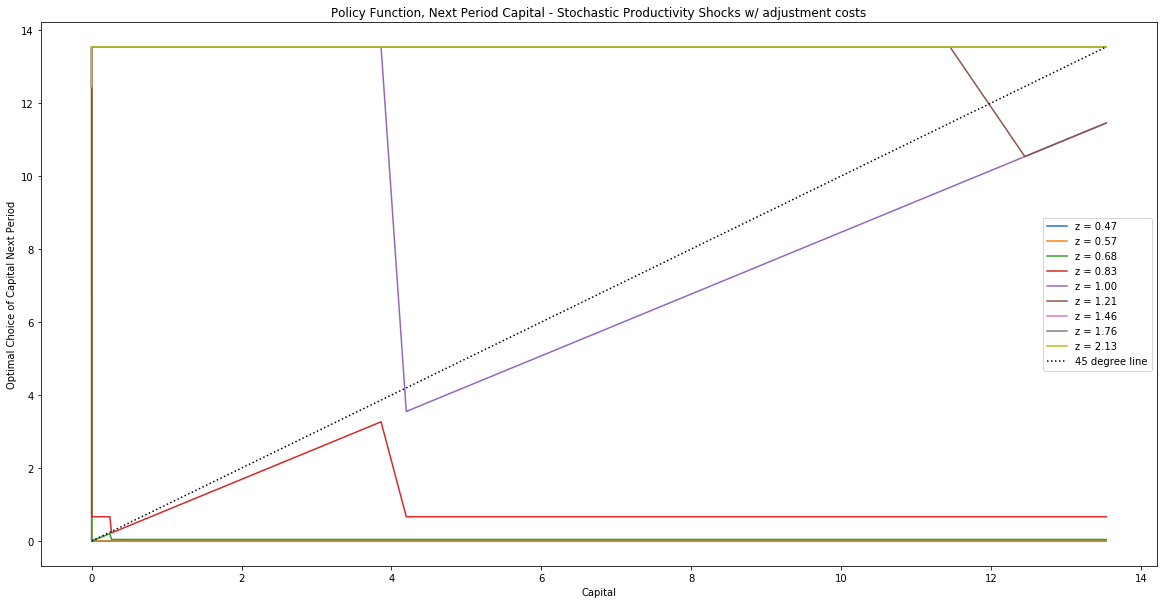

In [54]:
optK = kvec[PF]
pylab.rcParams['figure.figsize'] = (20, 10)
for i in range(9):
    plt.plot(kvec, optK[:, i], label=str('z = ' + "%.2f" %zvec[i]))
plt.plot(kvec, kvec, 'k:', label='45 degree line')
plt.xlabel('Capital')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.legend()
plt.title('Policy Function, Next Period Capital - Stochastic Productivity Shocks w/ ' +
          'adjustment costs')

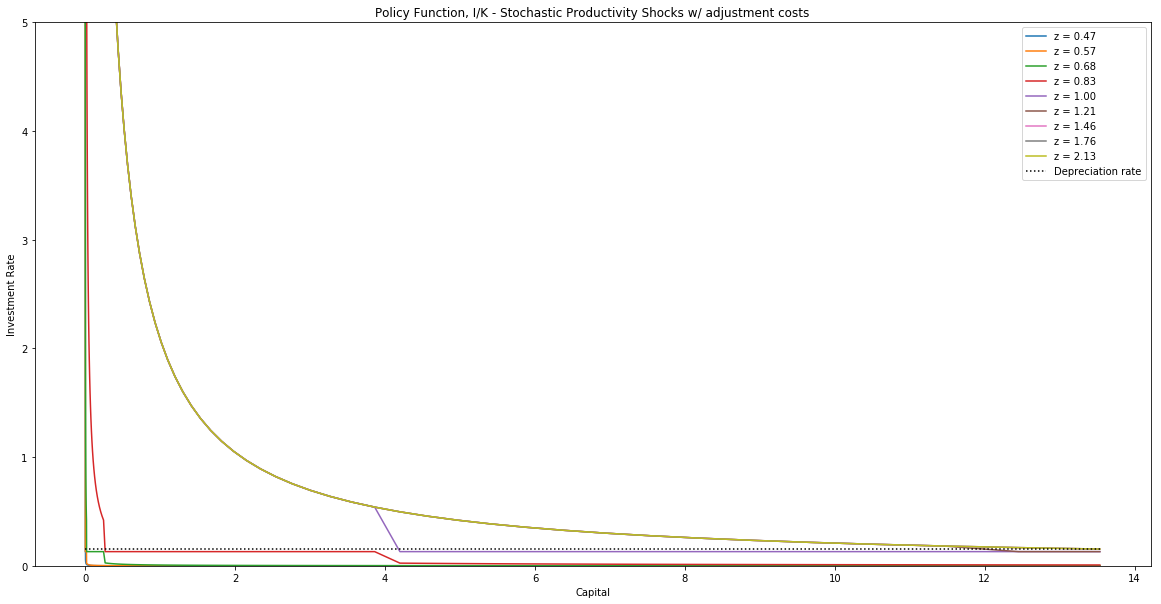

In [55]:
optI = optK - (1 - delta) * optK
pylab.rcParams['figure.figsize'] = (20, 10)
for i in range(9):
    plt.plot(kvec, optI[:,i]/kvec, label=str('z = ' + "%.2f" %zvec[i]))
plt.plot(kvec,(np.ones(kvec.shape[0])*delta), 'k:', label='Depreciation rate')
plt.xlabel('Capital')
plt.ylabel('Investment Rate')
plt.title('Policy Function, I/K - Stochastic Productivity Shocks w/ ' +
          'adjustment costs')
plt.legend()
plt.ylim(0, 5)
plt.show()

From the policy functions we see that firms with low capital invest a lot at the beginning, because the cost for investment is fixed. However, once their capital levels pass a certain threshold, they choose not to invest and let their capital stock depreciate. 